### Summary

1.Exploratory Data Analysis on NYC Taxi data <br>
2.Build a machine learning model to predict the duration of NYC taxi trip.

### Introduction

In this notebook, we will first study and visualise the data, engineer new features, and examine potential outliers.<br>
Finally, we will make a brief excursion into viewing this challenge as a classification problem and finish this notebook with a simple Ensemble model that provides a basic prediction.<br>
Dataset downloaded from : https://www.kaggle.com/code/neomatrix369/chaieda-nyc-taxi-trip-duration-analysis/input?select=train_test_extended.csv

### Libraries

In [1]:
#importing the python libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from geopy.distance import geodesic
import time
from IPython.display import clear_output         
import warnings
warnings.filterwarnings('ignore')
#https://github.com/TanmayKedari/Exploratory-Analysis-of-NYC-Taxi/blob/master/NYC%20Taxi%20Trip%20Duration.ipynb

In [2]:
taxi_data = pd.read_csv('/Users/johnsiraniperiandavar/jupiter_dir/nyc/data/train_test_extended.csv')
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083778 entries, 0 to 2083777
Data columns (total 26 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   id                      object 
 1   vendor_id               int64  
 2   pickup_datetime         object 
 3   dropoff_datetime        object 
 4   passenger_count         int64  
 5   pickup_longitude        float64
 6   pickup_latitude         float64
 7   dropoff_longitude       float64
 8   dropoff_latitude        float64
 9   store_and_fwd_flag      object 
 10  trip_duration           float64
 11  pickup_district         object 
 12  pickup_neighbourhood    object 
 13  dropoff_district        object 
 14  dropoff_neighbourhood   object 
 15  pickup_geonumber        float64
 16  dropoff_geonumber       float64
 17  day_period              object 
 18  month                   object 
 19  year                    int64  
 20  season                  object 
 21  weekday_or_weekend      object 

### Explore data

In [5]:
taxi_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_geonumber,day_period,month,year,season,weekday_or_weekend,regular_day_or_holiday,pickup_hour,day_name,financial_quarter
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,23463.843750,2. Afternoon,03. Mar,2016,2. Spring,Weekday,Regular day,17,1. Monday,4
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,23457.607803,4. Night,06. Jun,2016,3. Summer,Weekend,Regular day,0,7. Sunday,1
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,23453.810295,1. Morning,01. Jan,2016,1. Winter,Weekday,Regular day,11,2. Tuesday,4
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,23453.197052,3. Evening,04. Apr,2016,2. Spring,Weekday,Regular day,19,3. Wednesday,1
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,23466.880730,2. Afternoon,03. Mar,2016,2. Spring,Weekend,Regular day,13,6. Saturday,4


###### 1. Check if the dataset has any empty values

In [6]:
taxi_data.isna().sum()

id                             0
vendor_id                      0
pickup_datetime                0
dropoff_datetime          625134
passenger_count                0
pickup_longitude               0
pickup_latitude                0
dropoff_longitude              0
dropoff_latitude               0
store_and_fwd_flag             0
trip_duration             625134
pickup_district                0
pickup_neighbourhood           0
dropoff_district               0
dropoff_neighbourhood          0
pickup_geonumber               0
dropoff_geonumber              0
day_period                     0
month                          0
year                           0
season                         0
weekday_or_weekend             0
regular_day_or_holiday         0
pickup_hour                    0
day_name                       0
financial_quarter              0
dtype: int64

###### Empty values in the dropoff_time shows in the incomplete trips. We can remove these trips to reduce the dataset size.

In [7]:
taxi_data_cleaned = taxi_data.dropna()


###### 2. Lets look at the unique values in the object fields

In [8]:
print('Unique values in the fields')
for col in taxi_data_cleaned.columns:
    if taxi_data_cleaned[col].dtype == object and col not in ['id','pickup_datetime','dropoff_datetime','pickup_neighbourhood','dropoff_neighbourhood']:
        print(col,":",taxi_data_cleaned[col].unique())

Unique values in the fields
store_and_fwd_flag : ['N' 'Y']
pickup_district : ['Brooklyn' 'Manhattan' 'Staten Island' 'Queens' 'Outside NYC']
dropoff_district : ['Manhattan' 'Brooklyn' 'Staten Island' 'Queens' 'Outside NYC']
day_period : ['2. Afternoon' '4. Night' '1. Morning' '3. Evening']
month : ['03. Mar' '06. Jun' '01. Jan' '04. Apr' '05. May' '02. Feb']
season : ['2. Spring' '3. Summer' '1. Winter']
weekday_or_weekend : ['Weekday' 'Weekend']
regular_day_or_holiday : ['Regular day' 'Holiday (or Festival)']
day_name : ['1. Monday' '7. Sunday' '2. Tuesday' '3. Wednesday' '6. Saturday'
 '5. Friday' '4. Thursday']


In [9]:
print('Unique values in the vendor_id')
taxi_data_cleaned['vendor_id'].unique()

Unique values in the vendor_id


array([2, 1])

###### 3.Convert the pickup_datetime and dropoff_datetime datatype to datetime

In [10]:
taxi_data_cleaned['pickup_datetime'] = pd.to_datetime(taxi_data_cleaned['pickup_datetime'])
taxi_data_cleaned['dropoff_datetime'] = pd.to_datetime(taxi_data_cleaned['dropoff_datetime'])

###### 4.Calculate distance between pickup and dropoff coordinates using geodesic

In [11]:
distance = []
for index in taxi_data_cleaned['pickup_latitude'].index:
    distance.append(geodesic((taxi_data_cleaned['pickup_latitude'].iloc[index],taxi_data_cleaned['pickup_longitude'].iloc[index]),(taxi_data_cleaned['dropoff_latitude'].iloc[index],taxi_data_cleaned['dropoff_longitude'].iloc[index])).miles)
taxi_data_cleaned['distance'] = distance

###### Description on Features 
id - a unique identifier for each trip <br>
vendor_id - business provider id. possible values are 0 or 1 <br>
pickup_datetime - Trip pickup time<br>
dropoff_datetime - Trip end time<br>
passenger_count - Number of passengers in the vehicle<br>
pickup_longitude - Trip start longitude<br>
pickup_latitude - Trip start latitude<br>
dropoff_longitude - Trip end longitude<br>
dropoff_latitude - Trip end latitude<br>
pickup_district - Trip pickup district<br>
dropoff_district - Trip end district<br>
store_and_fwd_flag - possible values y or n<br>
day_period - possible values Afternoon,Night,Morning,Evening <br>
month : Month the trip was taken. Metric from pickup_datetime<br>
season : Season the trip was taken.Metric from pickup_datetime<br>
weekday_or_weekend : Weekday trip or weekend trip<br>
regular_day_or_holiday : Regular day or holiday trip<br>
day_name : day name <br>
pickup_hour: on which hour of the day the trip started <br>
financial_quarter: financial quarter <br>
trip_duration - Trip duration in seconds<br>
distance - Trip distance metric calculated from start lat/long and end lat/long<br>


### Data Analysis

###### Total trips  comparison charts by Vendor Id and Passenger

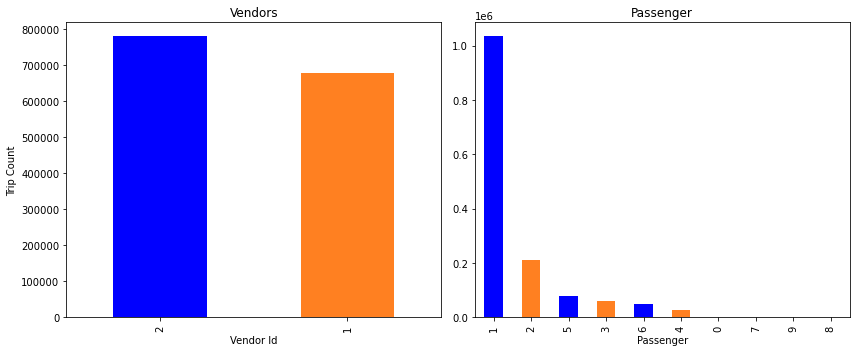

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = taxi_data_cleaned['vendor_id'].value_counts().plot(kind='bar',title="Vendors",ax=axes[0],color = ('blue',(1, 0.5, 0.13)))

ax1= taxi_data_cleaned['passenger_count'].value_counts().plot(kind='bar',title="Passenger",ax=axes[1],color = ('blue',(1, 0.5, 0.13)))
ax.set_ylabel("Trip Count")
ax.set_xlabel("Vendor Id")
ax1.set_xlabel("Passenger")
fig.tight_layout()

Each trip has either vendor id 1 or 0 and number of trips taken by vendor 2 is higher than 1 <br>
Most of the taxi's allows 1 to 4 passengers. Some of the big vehicles allow upto 6 passengers.The data looks legitimate.

### Comparing trips with pickup_district and dropoff_district

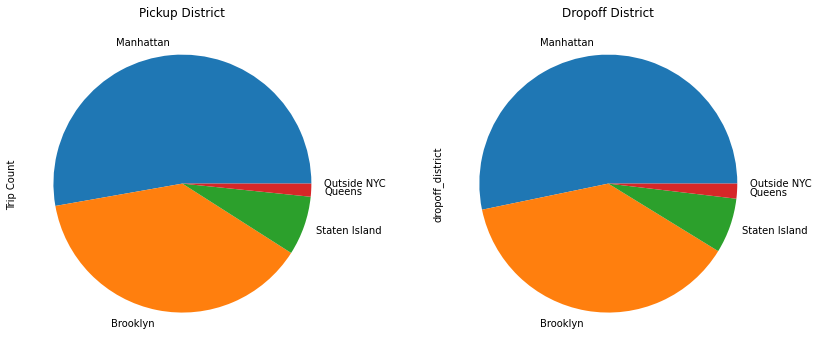

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,5))
ax = taxi_data_cleaned['pickup_district'].value_counts().plot(kind='pie',title="Pickup District",ax=axes[0])
ax1= taxi_data_cleaned['dropoff_district'].value_counts().plot(kind='pie',title="Dropoff District",ax=axes[1])
ax.set_ylabel("Trip Count")
fig.tight_layout()

###### Most of the pickup and dropoff are Manhatten and Brooklyn districts. Those 2 districts dominates both the trip pickup and dropoff

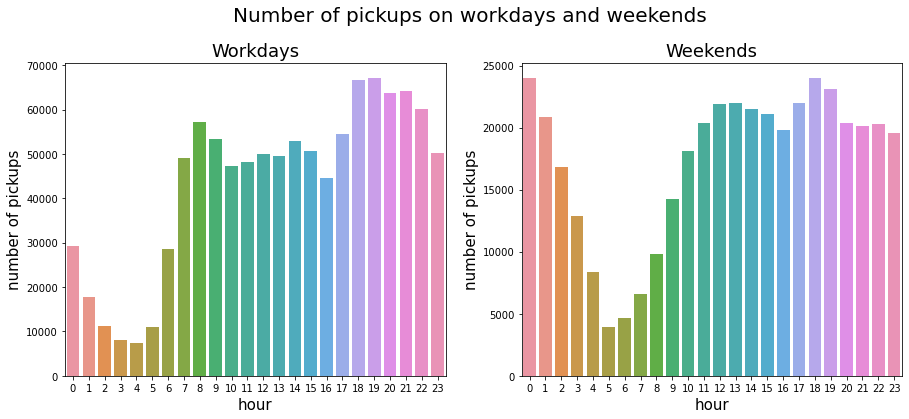

In [34]:
fig, axes = plt.subplots(figsize=(15,6), nrows=1, ncols=2)
workday_trips = taxi_data_cleaned.loc[taxi_data_cleaned['weekday_or_weekend']=='Weekday']
weekend_trips = taxi_data_cleaned.loc[taxi_data_cleaned['weekday_or_weekend']=='Weekend']

sns.countplot(ax=axes[0], x=workday_trips['pickup_hour'])
sns.countplot(ax=axes[1], x=weekend_trips['pickup_hour'])

axes[0].set_title('Workdays',fontsize = 18)
axes[0].set_xlabel('hour', fontsize=15)
axes[0].set_ylabel('Number of Pickups', fontsize=15)
axes[1].set_title('Weekends',fontsize = 18)
axes[1].set_xlabel('hour', fontsize=15)
axes[1].set_ylabel('Number of Pickups', fontsize=15)

fig.suptitle('Number of pickups on workdays and weekends',fontsize = 20)
plt.subplots_adjust(top = 0.85)
plt.show;

We can confirm from the charts above that people use taxi during the weekend more than weekdays.<br>
The trend shows midnight pickups are high during weekends than weekdays.

###### Trip vs Neighborhood Analysis

Lets create 2 new features in the dataset by adding neighborhood and district together.

In [67]:
taxi_data_cleaned['pickup_dist_neigh'] = taxi_data_cleaned['pickup_neighbourhood']+','+ taxi_data_cleaned['pickup_district']
taxi_data_cleaned['dropoff_dist_neigh'] = taxi_data_cleaned['dropoff_neighbourhood']+','+ taxi_data_cleaned['dropoff_district']

In [93]:
pickup_most = taxi_data_cleaned['pickup_dist_neigh'].value_counts(sort=True).nlargest(10)
dropoff_most = taxi_data_cleaned['dropoff_dist_neigh'].value_counts(sort=True).nlargest(10)
print('Top 10 Most Pickup Neighborhoods')
display(pickup_most)
print('Top 10 Most Dropoff Neighborhoods')
display(dropoff_most)

Top 10 Most Pickup Neighborhoods


Upper West Side,Manhattan      185599
Harlem,Manhattan               159106
East Harlem,Manhattan          155891
Bedford-Stuyvesant,Brooklyn    139263
South Slope,Brooklyn            69837
Hell's Kitchen,Manhattan        57064
West Village,Manhattan          52492
Clinton Hill,Brooklyn           45862
Fort Greene,Brooklyn            44221
Williamsburg,Brooklyn           43751
Name: pickup_dist_neigh, dtype: int64

Top 10 Most Dropoff Neighborhoods


Upper West Side,Manhattan      180186
Harlem,Manhattan               171050
East Harlem,Manhattan          159003
Bedford-Stuyvesant,Brooklyn    128719
South Slope,Brooklyn            66652
Hell's Kitchen,Manhattan        56182
Kensington,Brooklyn             53345
West Village,Manhattan          50176
Clinton Hill,Brooklyn           49391
Midtown,Manhattan               43365
Name: dropoff_dist_neigh, dtype: int64

In [94]:
pickup_least = taxi_data_cleaned['pickup_dist_neigh'].value_counts(sort=True).nsmallest(10)
dropoff_least = taxi_data_cleaned['dropoff_dist_neigh'].value_counts(sort=True).nsmallest(10)
print('Top 10 Least Pickup Neighborhoods')
display(pickup_least)
print('Top 10 Least Dropoff Neighborhoods')
display(dropoff_least)

Top 10 Least Pickup Neighborhoods


Richmond Hill,Queens           1
Woodhaven,Queens               1
Battery Park City,Manhattan    1
Navy Yard,Brooklyn             1
Rosedale,Queens                1
Cypress Hills,Brooklyn         1
Ozone Park,Queens              1
South Ozone Park,Queens        2
Tribeca,Manhattan              2
Jamaica,Queens                 2
Name: pickup_dist_neigh, dtype: int64

Top 10 Least Dropoff Neighborhoods


South Ozone Park,Queens         1
Rosedale,Queens                 1
Financial District,Manhattan    1
Ozone Park,Queens               1
Nolita,Manhattan                1
Cypress Hills,Brooklyn          2
Brownsville,Brooklyn            2
Red Hook,Brooklyn               2
Springfield Gardens,Queens      2
New Brighton,Staten Island      3
Name: dropoff_dist_neigh, dtype: int64

###### Trip distance Vs Trip Duration

<AxesSubplot:xlabel='distance', ylabel='trip_duration'>

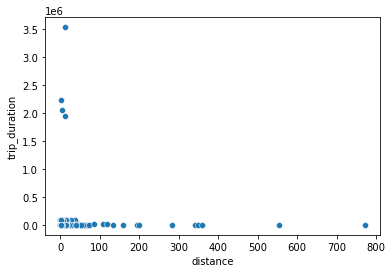

In [96]:
sns.scatterplot(data=taxi_data_cleaned, x="distance", y="trip_duration")

The plot shows some outliers in the distance and trip_duration field

In [114]:
print(taxi_data_cleaned['trip_duration'].min())
print(taxi_data_cleaned['trip_duration'].max())
print(taxi_data_cleaned['trip_duration'].mean())
taxi_data_cleaned[taxi_data_cleaned['trip_duration']>5000].shape[0]

1.0
3526282.0
959.4922729603659


3773

In [122]:
print(taxi_data_cleaned['distance'].min())
print(taxi_data_cleaned['distance'].max())
print(taxi_data_cleaned['distance'].mean())
taxi_data_cleaned[taxi_data_cleaned['distance']>30].shape[0]

0.0
770.8173365229512
2.1388794392733157


99

Remove trips with trip_duration over 1000 and distance over 10 miles

In [137]:
taxi_data_cleaned = taxi_data_cleaned[(taxi_data_cleaned['distance']<10) & (taxi_data_cleaned['trip_duration']<1000)]

In [138]:
taxi_data_cleaned.shape[0]

1044338

Chart after removing outliers in distance and trip_duration


<AxesSubplot:xlabel='distance', ylabel='trip_duration'>

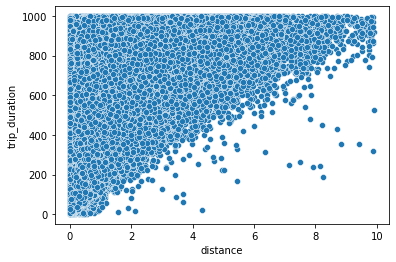

In [163]:
sns.scatterplot(data=taxi_data_cleaned, x="distance", y="trip_duration")

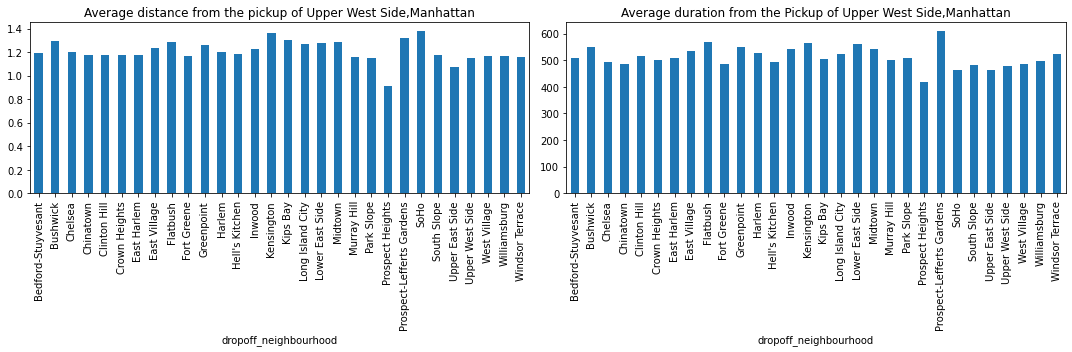

In [162]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
grp_by_pickup = taxi_data_cleaned[taxi_data_cleaned['pickup_dist_neigh']=='Upper West Side,Manhattan']\
                .groupby('dropoff_neighbourhood')['distance'].mean().plot(kind='bar',\
                title="Average distance from the pickup of Upper West Side,Manhattan",ax=axes[0])
grp_by_pickup = taxi_data_cleaned[taxi_data_cleaned['pickup_dist_neigh']=='Upper West Side,Manhattan']\
                .groupby('dropoff_neighbourhood')['trip_duration'].mean().plot(kind='bar',\
                title="Average duration from the Pickup of Upper West Side,Manhattan",ax=axes[1])
ax.set_ylabel("Trip Distance in miles")
ax.set_xlabel("DropOff Neighborhood")
ax1.set_xlabel("DropOff Neighborhood")
ax1.set_ylabel("Trip duration in seconds")
fig.tight_layout()


The trip distance of SoHo looks almost 1.4 miles and Prospect-Lefferts Gardens almost 1.3miles. But the trip duration for Soho is shorter than Prospect-Lefferts Gardens which could be the traffic zone.

###### Lets use labelencoder() to convert the categorical data into numerical field

In [169]:
for col in taxi_data_cleaned.columns:
    if taxi_data_cleaned[col].dtype == object and col not in ['id','pickup_datetime','dropoff_datetime','pickup_neighbourhood','dropoff_neighbourhood']:
     
        taxi_data_cleaned[col] = LabelEncoder().fit_transform(taxi_data_cleaned[col])


In [181]:
i = 0
for col in taxi_data_cleaned.columns:
    print(i,col)
    i+=1

0 id
1 vendor_id
2 pickup_datetime
3 dropoff_datetime
4 passenger_count
5 pickup_longitude
6 pickup_latitude
7 dropoff_longitude
8 dropoff_latitude
9 store_and_fwd_flag
10 trip_duration
11 pickup_district
12 pickup_neighbourhood
13 dropoff_district
14 dropoff_neighbourhood
15 pickup_geonumber
16 dropoff_geonumber
17 day_period
18 month
19 year
20 season
21 weekday_or_weekend
22 regular_day_or_holiday
23 pickup_hour
24 day_name
25 financial_quarter
26 distance
27 pickup_dist_neigh
28 dropoff_dist_neigh


###### Correlation Matrix

In [189]:
x = taxi_data_cleaned.iloc[:, [1, 4,9,10, 11,15,16,17,18,20,21,22,23,24,25,26]].values
y = taxi_data_cleaned.iloc[:,10].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state = 7294)

In [194]:
from scipy.stats import pearsonr
df1 = pd.DataFrame(np.concatenate((x_train,y_train.reshape(len(y_train),1)),axis=1))
df1.columns = df1.columns.astype(str)

features = df1.iloc[:,:10].columns.tolist()
target = df1.iloc[:,10].name

correlations = {}
for f in features:
    data_temp = df1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + 'trip_duration'
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
7 vs trip_duration,0.116243
5 vs trip_duration,-0.042012
6 vs trip_duration,-0.033143
1 vs trip_duration,0.029765
3 vs trip_duration,-0.026460
4 vs trip_duration,-0.018341
9 vs trip_duration,-0.012619
8 vs trip_duration,-0.003722
0 vs trip_duration,0.002771
2 vs trip_duration,-0.001978
